In [1]:
import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('bright')
from Energy_Levels import MoleculeLevels
from Energy_Levels import branching_ratios, Calculate_TDMs,Calculate_TDM_evecs
from functools import partial
np.set_printoptions(precision=5, suppress=True)
from tabulate import tabulate
from matplotlib.collections import LineCollection

In [2]:
%matplotlib inline

In [3]:
import copy

def select_dipole(dipole,TDM_func):
    if dipole == 'z':
        TDM = TDM_func(0)
    elif dipole == '+':
        TDM = TDM_func(1)
    elif dipole == '-':
        TDM = TDM_func(1)
    elif 'x' in dipole:
        TDMx = -1/np.sqrt(2)*(TDM_func(1)-TDM_func(-1))
        if dipole=='x':
            TDM=TDMx
        elif dipole=='x+z' or dipole=='z+x':
            TDM = 1/np.sqrt(2)*(abs(TDMx)+abs(TDM_func(0)))
    else:
        TDM = 1/np.sqrt(3)*(abs(TDM_func(-1))+abs(TDM_func(0))+abs(TDM_func(1)))
    return TDM

def lorentzian(f,f0,g,N):
    return N*(g/2)**2 /((f-f0)**2 + (g/2)**2)


def simulate_spectra(field_EB,state_g,state_e,g_idx,e_idx,ret_str =False,freq_array=None,diagonalize=False,T=4,origin = 0,P_adjust=False,square=True,pad=10,dipole='z',cm=True,thresh=1e-3,g=7.9/(29979.2458),dip=False,make_lorentzians=True,plot=True):
    E0, B0 = field_EB
    if diagonalize:
        G_evals,G_evecs = copy.deepcopy(state_g.eigensystem(E0,B0))
        E_evals,E_evecs = copy.deepcopy(state_e.eigensystem(E0,B0))
    else:
        G_evals,G_evecs = copy.deepcopy(state_g.evals0),copy.deepcopy(state_g.evecs0)
        E_evals,E_evecs = copy.deepcopy(state_e.evals0),copy.deepcopy(state_e.evecs0)
    TDM_func = partial(Calculate_TDMs,Ground=state_g,Excited=state_e,Ez=E0,Bz=B0,q=[0])
    TDM_EB = select_dipole(dipole,TDM_func)
    if cm:
        E_evals/=29979.2458
        G_evals/=29979.2458
    E_evals+= origin
    dE_EB = np.subtract.outer(E_evals, G_evals)
    
    all_param = []
    flist = []
    TDMlist = []
    t_str_list = []
    for i in g_idx:
        vec_g = G_evecs[i,:]
        q_g = abs(vec_g).argmax()
        for j in e_idx:
            vec_e = E_evecs[j,:]
            q_e = abs(vec_e).argmax()
            Je,Me = [state_e.q_numbers[_q][q_e] for _q in ['J','M']]
            Pe = {1:'+',-1:'-'}[state_e.parities[j]]
            Ng,Jg,Mg = [state_g.q_numbers[_q][q_g] for _q in ['N','J','M']]
            Pg = {1:'+',-1:'-'}[state_g.parities[i]]
            if Me % 1 == 0:
                Me=int(Me)
                Mg = int(Mg)
#                 if N==1:
#                     boltz=1
#                 else:
#                     boltz = np.exp(-(0.352*(N*(N+1)-2)/T))
            if cm:
                boltz = np.exp(-G_evals[i]*1.439/T)
            else:
                boltz = np.exp(-4.799e-5*G_evals[i]/T)
            _TDM = TDM_EB[j,i]
            _dE = dE_EB[j,i]
            if _dE<0:
                continue
            if abs(_TDM) < thresh:
                continue
            flist.append(_dE)
            if square:
                _TDM = np.square(_TDM)
            _TDM*= boltz
            if Jg>Je and P_adjust:
                _TDM*=(2*Je+1)/(2*Jg+1)
            all_param.append([_dE,g,_TDM])
            TDMlist.append(_TDM)
            with_F = False
            if ret_str:
                if with_F:
                    t_str = '(N={Ng}{Pg},J={Jg},F={Fg},M={Mg})->(J={Je}{Pe},F={Fe},M={Me})'.format(Je=Je,Fe=Fe,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Fg=Fg,Mg=Mg,Pg=Pg)
                else:
                    dJ = Je-Jg
                    PQR_J = {-1:'P', 0:'Q', 1:'R'}[dJ]
                    dJN = Jg - Ng
                    dN = (Je-0.5) - Ng
                    PQR_N = {-2:'O',-1:'P', 0:'Q', 1:'R'}[dN]
                    F12 = {0.5:'1',-0.5:'2'}[dJN]
                    full_str = []
                    pqr_str = r'$^{{{pqr_n}}} {{{pqr_j}}}_{{1{{{fi}}}}}({{{Ng}}}^{{{{{Pg}}}}})$'.format(pqr_n=PQR_N,pqr_j=PQR_J,fi=F12,Ng=Ng,Pg=Pg)
                    full_str.append(pqr_str)
                    qn_str = ['{Ng}, {Jg2}/2'.format(Ng=Ng,Jg2=int(Jg*2)),'{Je2}/2'.format(Je2=int(Je*2))]
                    full_str.extend(qn_str)
                    freq_str = ['{}'.format(np.round(_dE,4))]
                    full_str.extend(freq_str)
#                     '\t' + r'$N={{{Ng}}}^{{{{{Pg}}}}},J={{{Jg}}},M={{{Mg}}} \rightarrow J={{{Je}}}^{{{{{Pe}}}}},M={{{Me}}}$'.format(Je=Je,Me=Me,Pe=Pe,Ng=Ng,Jg=Jg,Mg=Mg,Pg=Pg)
                t_str_list.append(full_str)
    if flist==[]:
        flist.append(0)
        all_param.append([0,g,0])
        TDMlist.append(0)
    if make_lorentzians:
        if freq_array is None:
            fmin = min(flist)-pad*g
            fmax = max(flist)+pad*g
            n=int((fmax-fmin)/(g/20))
            freq = np.linspace(fmin,fmax,n)
        else:
            freq = freq_array
            n = len(freq_array)
        tot_lor = np.zeros(n)
        for param in all_param:
            tot_lor+=lorentzian(freq,*param)
        if dip:
            tot_lor*=-1
        if plot:
            plt.figure()
            plt.plot(freq,tot_lor)
        if ret_str:
            return flist,(freq,tot_lor),TDMlist,t_str_list
        else:
            return flist,(freq,tot_lor),TDMlist
    else:
        if ret_str:
            return flist,TDMlist,t_str_list
        else:
            return flist,TDMlist

In [78]:
g = MoleculeLevels.initialize_state('CaOH','40','X000',[0,1,2,3,4,5,6,7,8,9],M_values = 'pos',I=[0,0],S=1/2,round=8,P_values=[1/2])
e = MoleculeLevels.initialize_state('CaOH','40','B000',[0,1,2,3,4,5,6,7,8,9,10],M_values = 'pos',I=[0,0],S=1/2,round=8,P_values=[1/2])
g.eigensystem(0,1e-3)
e.eigensystem(0,1e-3)
gidx = g.select_q({'N':[0,1,2,3,4,5,7,8,9,10,11]})
eidx = e.select_q({'N':[0,1,2,3,4,5,6,7,8,9,10,11,12]})

In [79]:
g.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 10023.0841,
 'D': 0.01154,
 'Gamma_SR': 34.7593,
 'bF': 2.602,
 'c': 2.053,
 'b': 1.9176666666666664,
 'muE': 0.73749858}

In [80]:
e.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 10175.2,
 'Gamma_SR': -1307.54,
 'bF': 0.10407999999999999,
 'c': 0.08212,
 'b': 0.07670666666666666,
 'muE': 0.374538528}

In [83]:
g.update_params({
    'D':0,
    'Be': 5868,
    'Gamma_SR':200,
})

e.update_params({
    'Be':5855,
    'Gamma_SR':-25000
})

Successfully converted eigenvectors from bBJ to aBJ
Successfully converted eigenvectors from bBJ to aBJ


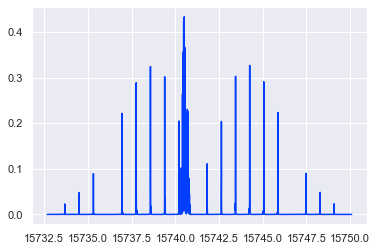

In [84]:
# gidx = g.select_q({'N':[2]})
# eidx = e.select_q({'N':[3],'J':[7/2]})
gidx = g.select_q({'N':[0,1,2,3,4,5,7,8,9,10,11]})
eidx = e.select_q({'N':[0,1,2,3,4,5,6,7,8,9,10,11,12]})
flist,(freq,tot_lor),TDMlist = simulate_spectra([0,1e-3],g,e,gidx,eidx,ret_str =False,freq_array=None,diagonalize=False,T=6,origin = 15740.6,P_adjust=False,square=True,pad=300,dipole='z',cm=True,thresh=1e-3,g=100/(29979.2458),dip=False,make_lorentzians=True,plot=True)

In [51]:
flist

[15741.637184203842, 15741.627177249826, 15741.62717719997]

(15740.5, 15742.0)

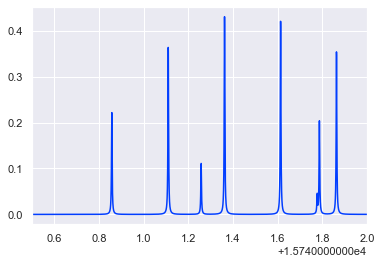

In [63]:
plt.plot(freq,tot_lor)
plt.xlim(15740.5,15742)

In [41]:
flist

[15740.907212500517,
 15741.157385540755,
 15740.215200522101,
 15741.637184203842,
 15740.205193568085,
 15741.210222149524,
 15741.627177249826,
 15741.21022213706,
 15741.62717719997,
 15739.742807062945,
 15742.112779892555,
 15739.742807013088,
 15739.992980053326,
 15742.112779887215,
 15739.726128789633,
 15741.512364510516,
 15742.09610166376,
 15739.726128802096,
 15741.512364505174,
 15742.096101631707,
 15741.512364499831,
 15742.096101599656,
 15739.269546330019,
 15742.587508312248,
 15739.269546297968,
 15739.686501360879,
 15742.58750830928,
 15739.26954626592,
 15739.68650136622,
 15742.587508306315,
 15739.2461967659,
 15741.813639602486,
 15742.564158806295,
 15739.24619677124,
 15741.813639599517,
 15742.564158782552,
 15739.246196776583,
 15741.81363959655,
 15742.564158758812,
 15741.813639593582,
 15742.564158735071,
 15738.795418328073,
 15743.061369465078,
 15738.79541830433,
 15739.379155404155,
 15743.061369463188,
 15738.79541828059,
 15739.379155407123,
 157